# Judea Pearl e a Escada da Causalidade

      /---/ Contrafatos  
     /---/ Intervenção  
    /---/ Associação

Um sumário dos três degraus da Escada da Causalidade

|        Degrau         	|   Ação   	|                   Questão                  	|
|:-------------------:	|:----------:	|:-------------------------------------------:	|
|   Associação (1)   	| Observar  	| Como observar X muda minha crença em Y? 	|
|  Intervenção (2)   	|   Doing    	|       O que acontece com Y se eu fizer X?      	|
| Contrafatual (3)  	| Imaginar  	|      Se eu tivesse feito X, o que seria de Y?      	|




## DEGRAU 1 --- ASSOCIAÇÃO: Structural Causal Models (SCMs)
Ferramentas para codificar relações causais entre variáveis

## Recriando uma SCM

Exemplo: Imagine que você administra uma loja virtual de livros. Os livros A e B serão variáveis endógenas e seus valores serão a probabilidade de um cliente comprá-los. Neste exemplos, temos como relevante a probabilidade de uma pessoa comprar o livro A, dado que esta já comprou o livro B.

Primeiramente definimos uma SCM que possa gerar dados com uma probabilidade condicional P(book A|book B) seja diferente de 0

    (U0) -> A -> B
    (U1) -> B
  
(U0) e (U1) são variáveis exógenas (noise bariables). São representados por nós raiz no grafo (não são descendentes de nenhuma outra variável)

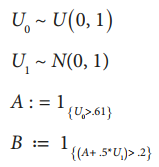

In [ ]:
import numpy as np
from scipy import stats

In [ ]:
class BookNode:
  def __init__(self, random_seed=None):
    self.random_seed = random_seed
    self.u0 = stats.uniform()
    self.u1 = stats.norm()

  def sample(self, sample_size=100):
    # amostras da SCM
    if self.random_seed:
      np.random.seed(self.random_seed)

    u0 = self.u0.rvs(sample_size)
    u1 = self.u1.rvs(sample_size)

    a = u0 > .61
    b = (a + .5*u1) > .2

    return a, b

In [ ]:
# cria SCM
scm = BookNode(random_seed=45)

# 100 amostras
book_a, book_b = scm.sample(100)

In [ ]:
a = book_a.size
a


100

In [ ]:
# P(A) e P(B)
p_A = book_a.sum() / book_a.shape[0]
# num de ocorrencias de a = true dividido pelo num de amostras de a
p_B = book_b.sum() / book_b.shape[0]

# P(A|B) = P(A, B)/P(B)
# np.where(a, b, 0) = array no dom {0,1} onde array[n] = 1(True) se a[n] e b[n]
p_a_given_b = (np.where(book_a, book_b, 0)).sum()/ book_b.sum()
p_b_given_a = (np.where(book_a, book_b, 0)).sum()/ book_a.sum()

print(f'P(A|B) = {p_a_given_b:0.3f}')
print(f'P(B|A) = {p_b_given_a:0.3f}')

P(A|B) = 0.638
P(B|A) = 0.949


# Regressão, observações e intervenções

Reg. linear é uma técnica de análise de dados que prevê o valor de dados desconhecidos usando outro valor de dados relacionado e conhecido.

- modela matematicamente a variável desconhecida ou dependente e a variável conhecida ou independente como uma equação linear.

- modelo simples -- uma variável preditora

$$ y_i = α + βx_i $$

## Construindo um exemplo simples
- $\alpha^*=1.12, \beta^*=0.93$ e é adicionado um noise (ruído?) ϵ que é escolhida de uma distribuição normal (média 0/nula e desvio padrão unitário), escalado em 0.5:

$$ y_i = 1.12 + 0.93x_i + 0.5ϵ_i $$

onde $ϵ ∼ \mathcal{N}(0,1)$

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('default')
plt.style.use('fivethirtyeight')

COLORS = [
    '#00B0F0',
    '#FF0000'
]

# definir random seed e num de amostras
np.random.seed(45)
N_SAMPLES = 5000

# definir parâmetros do modelo
alpha = 1.12
beta = 0.93
epsilon = np.random.randn(N_SAMPLES)


# utilizar modelo para gerar dados
X = np.random.randn(N_SAMPLES)
y = alpha + beta*X + 0.5*epsilon
X = sm.add_constant(X)

# fit regression model
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 1.681e+04
Date:                Thu, 24 Aug 2023   Prob (F-statistic):               0.00
Time:                        13:40:04   Log-Likelihood:                -3615.0
No. Observations:                5000   AIC:                             7234.
Df Residuals:                    4998   BIC:                             7247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1243      0.007    159.391      0.0

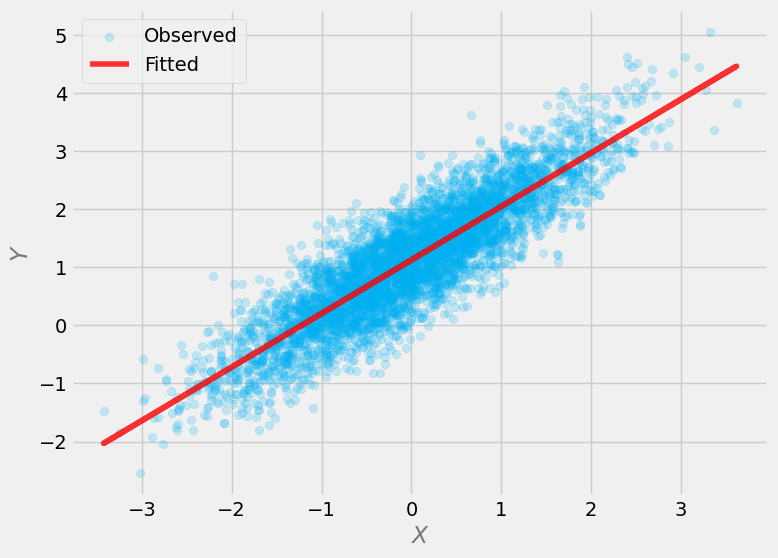

In [ ]:
# gerar predições
y_pred = fitted_model.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 1], y, color=COLORS[0], label='Observed', alpha=.2)
plt.plot(X[:, 1], y_pred, color=COLORS[1], label='Fitted', alpha=.8)
plt.xlabel('$X$', alpha=.5)
plt.ylabel('$Y$', alpha=.5)
legend = plt.legend()
plt.show()

## Visualização do modelo


In [ ]:
import graphviz as gv

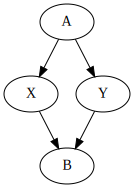

In [ ]:
# criar grafo direcionado
g1 = gv.Digraph(format='png')

# adicionar nós
nodes = ['A', 'X', 'B', 'Y']
[g1.node(n) for n in nodes]

g1.edges(['AX', 'AY', 'XB', 'YB'])

g1.render()

g1

## Variáveis de Controle e SCMs

In [ ]:
# random seed
np.random.seed(45)

# Definir tam da amostra
N_SAMPLES = 1000

# Definindo a SCM (coeficientes escolhidos arbitrariamente)
a = np.random.randn(N_SAMPLES)

x = 2*a + 0.5 * np.random.randn(N_SAMPLES)
y = 2*a + 0.5 * np.random.randn(N_SAMPLES)

b = 1.5*a + 0.75*y


In [ ]:
# definir quatro modelos
variants = [
    [x],
    [x, a],
    [x, b],
    [x, a, b]
]

# ajustar os modelos iterativamente e guardar resultados
results = []
for variant in variants:
  X = sm.add_constant(np.stack(variant).T)
  model = sm.OLS(y, X)
  fitted_model = model.fit()

  results.append((fitted_model.params, fitted_model.pvalues))
  print(f'Params: {fitted_model.params.round(3)}')
  print(f'p-vals: {fitted_model.pvalues.round(3)}')
  print(f'Signif: {fitted_model.pvalues <= .05}\n')

Params: [-0.02   0.947]
p-vals: [0.359 0.   ]
Signif: [False  True]

Params: [-0.011  0.014  1.967]
p-vals: [0.488 0.657 0.   ]
Signif: [False False  True]

Params: [-0.002 -0.193  0.802]
p-vals: [0.734 0.    0.   ]
Signif: [False  True  True]

Params: [ 0.    -0.    -2.     1.333]
p-vals: [0. 0. 0. 0.]
Signif: [ True  True  True  True]

